In [51]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.6.0


In [52]:
train_data_path ='./dataset/train.csv'
train = pd.read_csv(train_data_path)

num_of_train_data = train.shape[0]

test_data_path ='./dataset/test.csv'
test = pd.read_csv(test_data_path)

训练数据共1460个样本，81个维度，其中，Id是每个样本的唯一编号，SalePrice是房价，也是我们要拟合的目标值。其他维度（列）有数值类特征，也有非数值列，或者叫分类特征，英文为Categorical。

In [53]:
train.shape

(1460, 81)

In [54]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [55]:
# 房价，要拟合的目标值
target = train.SalePrice

# 输入特征，可以将SalePrice列扔掉
train.drop(['SalePrice'],axis = 1 , inplace = True)

# 将train和test合并到一起，一块处理特征，得到相同的特征值，方便预测test的房价
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

## 对数据进行简单的特征工程

1. 对于数值类特征，过滤掉带有空值的列。
2. 对于非数值类特征，过滤掉带有空值的列，同时进行One-Hot编码。

In [56]:
# 选出非空列
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [57]:
num_cols = get_cols_with_no_nans(combined, 'num')
cat_cols = get_cols_with_no_nans(combined, 'no_num')

# 过滤掉含有缺失值的特征
combined = combined[num_cols + cat_cols]

print(num_cols[:5])
print ('Number of numerical columns with no nan values: ',len(num_cols))
print(cat_cols[:5])
print ('Number of non-numerical columns with no nan values: ',len(cat_cols))

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
Number of numerical columns with no nan values : 25
['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope']
Number of non-numerical columns with no nan values : 20


In [58]:
# 对分类特征进行One-Hot编码
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            # pandas.get_dummies 可以对分类特征进行One-Hot编码
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            # drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [59]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [60]:
class Net(nn.Module):
    def __init__(self, features):
        super(Net, self).__init__()
        
        self.linear_relu1 = nn.Linear(features, 128)
        self.linear_relu2 = nn.Linear(128, 256)
        self.linear_relu3 = nn.Linear(256, 256)
        self.linear_relu4 = nn.Linear(256, 256)
        self.linear5 = nn.Linear(256, 1)
        
    def forward(self, x):
        
        y_pred = self.linear_relu1(x)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu2(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu3(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu4(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear5(y_pred)
        return y_pred

In [62]:
# 训练数据集特征
train_features = torch.tensor(combined[:num_of_train_data].values, dtype=torch.float)
# 训练数据集目标
train_labels = torch.tensor(target.values, dtype=torch.float).view(-1, 1)
# 测试数据集特征
test_features = torch.tensor(combined[num_of_train_data:].values, dtype=torch.float)

print("train data size: ", train_features.shape)
print("label data size: ", train_labels.shape)
print("test data size: ", test_features.shape)

train data size: torch.Size([1460, 149])
label data size: torch.Size([1460, 1])
test data size: torch.Size([1459, 149])


In [63]:
model = Net(features=train_features.shape[1])
# 使用均方误差作为损失函数
criterion = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [65]:
losses = []

# 训练500轮
for t in range(500):
    y_pred = model(train_features)
    
    loss = criterion(y_pred, train_labels)
    # print(t, loss.item())
    losses.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    # 将神经网络中各参数的梯度清零。
    # PyTorch的backward()方法计算梯度会默认将本次计算的梯度与缓存中已有的梯度加和。
    # 必须在反向传播前先清零。
    optimizer.zero_grad()

    # 反向传播，计算各参数对于损失loss的梯度
    loss.backward()

    # 根据刚刚反向传播得到的梯度更新模型参数
    optimizer.step()

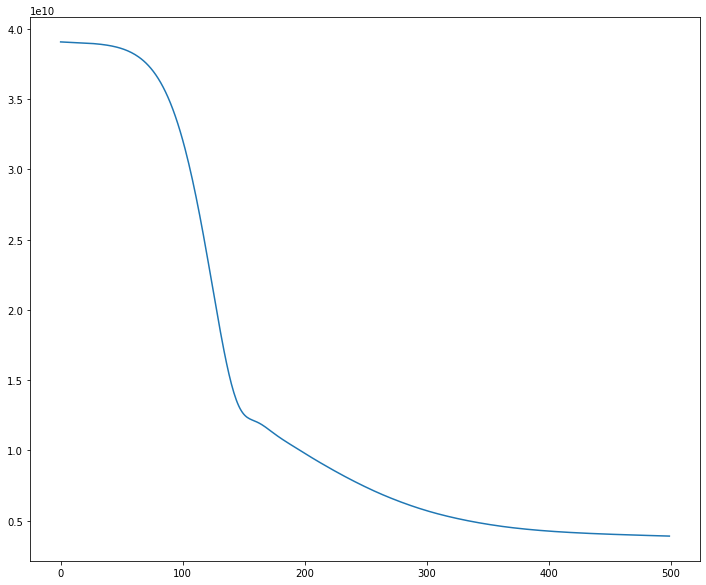

In [66]:
# 绘制训练过程的损失变化
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses)), losses)
plt.show()

In [67]:
print(model)

Net(
  (linear_relu1): Linear(in_features=149, out_features=128, bias=True)
  (linear_relu2): Linear(in_features=128, out_features=256, bias=True)
  (linear_relu3): Linear(in_features=256, out_features=256, bias=True)
  (linear_relu4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=1, bias=True)
)


In [68]:
model_total_params = sum(p.numel() for p in model.parameters())
print("model total parameters: ", model_total_params)

model total parameters:  184065


In [72]:
predictions = model(test_features).detach().numpy()
my_submission = pd.DataFrame({'Id':pd.read_csv('./dataset/test.csv').Id,'SalePrice': predictions[:, 0]})
my_submission.to_csv('{}.csv'.format('./dataset/submission'), index=False)

In [75]:
model_sequential = nn.Sequential(
          nn.Linear(train_features.shape[1], 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 1)
        )

optimizer_sequential = torch.optim.Adam(model_sequential.parameters(), lr=1e-4)

In [76]:
losses_sequential = []

# 训练500轮
for t in range(500):
    y_pred = model_sequential(train_features)
    
    loss = criterion(y_pred, train_labels)
    # print(t, loss.item())
    losses_sequential.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer_sequential.zero_grad()
    loss.backward()
    optimizer_sequential.step()

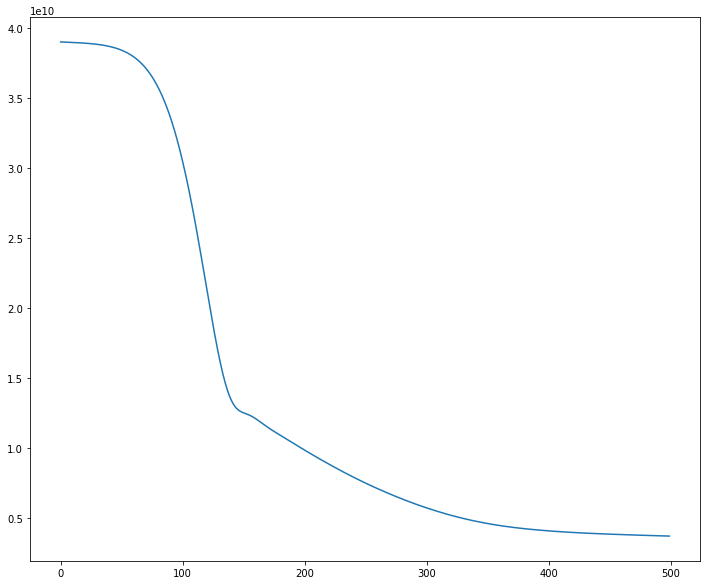

In [77]:
# 绘制训练过程的损失变化
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses_sequential)), losses_sequential)
plt.show()

In [78]:
print(model_sequential)

Sequential(
  (0): Linear(in_features=149, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=True)
)


In [79]:
model_sequential_total_params = sum(p.numel() for p in model_sequential.parameters())
print("model total parameters: ", model_sequential_total_params)

model total parameters:  184065
